In [21]:
#from lib import praatUtil
import sys
import numpy as np
import librosa
from pydub import AudioSegment as audioseg
from scipy.signal import get_window
from waveform_analysis.freq_estimation import (freq_from_crossings,
                                               freq_from_fft,
                                               freq_from_autocorr,
                                               freq_from_hps)

from scipy.io import wavfile
import calendar
import time
import math
import wave
import struct
import soundfile as sf
from soundfile import SoundFile
from matplotlib import pyplot as plt
from pydub import AudioSegment
import logging
import json

In [22]:
import amfm_decompy
import amfm_decompy.pYAAPT as pyaapt
import amfm_decompy.pyQHM as pyqhm
import amfm_decompy.basic_tools as basic
import os.path

In [47]:
TEN_SECONDS = 10 * 1000
THIRTY_SECONDS = 30 * 1000
SAMPLE_RATE = 48000
SAMPLE_RATE2 = 44100
MAX_NUM = 280.0
MIN_NUM = 55.0
FILE_NAME = "rawData/testRawData.wav"
MP3_FILE_NAME = "rawData/testRawData.mp3"
FILE_NAME_CHILD01 = "rawData/child01.wav"
FILE_NAME_CHILD02 = "rawData/child02.wav"
FILE_NAME_WOMEN = "rawData/female.wav"
FILE_NAME_MEN = "rawData/mono_male_wav.wav"
output_JSON = {}
output_JSON["Result"] = []

In [48]:
def wav_test():
    #FILENAME = "rawData/testRawData.wav"
    freq = 440.0
    data_size = 40000
    frate = 1000.0
    amp = 64000.0
    nchannels = 2
    sampwidth = 2
    framerate = int(frate)
    nframes = data_size
    comptype = "NONE"
    compname = "not compressed"
    data = [(math.sin(2 * math.pi * freq * (x / frate)),
        math.cos(2 * math.pi * freq * (x / frate))) for x in range(data_size)]
    try:
        wav_file = wave.open(FILE_NAME, 'w')
        wav_file.setparams(
            (nchannels, sampwidth, framerate, nframes, comptype, compname))
        for values in data:
            for v in values:
                wav_file.writeframes(struct.pack('h', int(v * amp / 2)))
    finally:
        wav_file.close()

In [49]:
def loadFile(fileName):
    sf = SoundFile(fileName)
    signal = sf.read()
    channels = sf.channels
    sample_rate = sf.samplerate
    sf.close()
    return signal, channels, sample_rate

In [50]:
def splitAudio(SpeechFileName):
    wavClipList = []
    wavClipList = audioseg.from_file(SpeechFileName)
    return wavClipList

In [51]:
def fft_frequence_estimate(signal,sample_rate):
    _freq = freq_from_fft(signal, sample_rate)
    return _freq

In [52]:
def crossings_frequence_estimate(signal,sample_rate):
    _freq = freq_from_crossings(signal, sample_rate)
    return _freq

## Utility Functions of Converting Audio Bytes to Array

In [53]:
def ConvertWaveByte2Array(file):
     
    waveFile = wave.open(file, 'r')
    samples = []
 
    # Gets total number of frames
    length = waveFile.getnframes()
     
    # Read them into the frames array
    for i in range(0,length):
        waveData = waveFile.readframes(i)
        data = struct.unpack("%ih"%2, waveData)
         
        # After unpacking, each data array here is actually an array of ints
        # The length of the array depends on the number of channels you have
         
        # Drop to mono channel
        samples.append(int(data[0]))
     
    samples = array(samples)
    return samples

In [54]:
def WavByteToNDArray():
    frames = wavfile.readframes(nsamples)
    ch1 = np.zeros(nsamples)
    ch2 = np.zeros(nsamples)
    int2float = (2**23)-1
    for x in np.arange(int(nsamples)):
        ch1_24bit_sample = frames[x*6:x*6+3]
        ch2_24bit_sample = frames[x*6+3:x*6+6]
        ch1_32bit_sample = bit24_2_32(ch1_24bit_sample)
        ch2_32bit_sample = bit24_2_32(ch2_24bit_sample)
        ch1[x]=struct.unpack('i',ch_32bit_sample)[0]
        ch2[x]=struct.unpack('i',ch_32bit_sample)[0]
        ch1[x]=ch1[x]/int2float
        ch2[x]=ch2[x]/int2float

def bit24_2_32(strbytes):
    if strbytes[2] < '\x80':
       return strbytes+'\x00'
    else:
       return strbytes+'\xff'

In [55]:
def ConvertStereo2Mono(TwoChannelFile,MonoFile):
    monosound = AudioSegment.from_wav(TwoChannelFile)
    monosound = monosound.set_channels(1)
    monosound.export(MonoFile, format="wav")

In [56]:
def wave_run():
    # one second contains 48000 frames, one frame contains 4 bytes
    # so 30 seconds contain 1440000
    #FName = "rawData/testRawData.wav"
    #FName = "rawData/child01.wav"
    wf = wave.open(FILE_NAME,'rb')
    frames = wf.getnframes()
    audioArray = wf.readframes(frames)
    bytes_per_frame = int(len(audioArray)/frames)
    print("Bytes per frame are {}".format(bytes_per_frame))
    print("the length of audioArray is {}".format(len(audioArray)))
    #print("frames type is {}, and shape is {}".format(type(audioArray),audioArray.shape))
    framerate = wf.getframerate()
    seconds = frames/framerate
    
    #print("The total frame is {}, and total seconds are {}".format(frames,seconds))
    
    #calculating one second contains how many frames: we get 48000 frames per second
    #frames_per_second = int(frames/seconds)
    print("One Second contains {} frames".format(framerate))
    __loops =int(frames / framerate)
    print("The __loop has values {}".format(__loops))
    start = 0
    end = 0
    for idx in range(__loops):
        start = idx * framerate
        end = (idx+1) * framerate
    #print("Frames:{}, Sample_Rate:{}, Seconds:{} ".format(frames,sr,seconds))

In [57]:
def appRun():
    #FName = "rawData/testRawData.wav"
    #FName = "rawData/male.wav"
    audioDataList, channels, sample_rate = loadFile(FILE_NAME)
    print("sample rate is {}".format(sample_rate))
    print("channel is : {}".format(channels))
    #print(type())
    _audio_len = len(audioDataList)
    _start = 0
    _end = 0
    total_seconds = int(_audio_len / sample_rate)
    frames_per_30_seconds = sample_rate * 30
    print("Frames every 30 seconds is {}".format(frames_per_30_seconds))
    loop_30 = int(_audio_len / frames_per_30_seconds)
    print("total loop is {}".format(loop_30))
    #print("frames per second is {}".format(total_seconds))
    #loops = int((int(_audio_len/sample_rate))/30)
    #sec_loops = int(_audio_len/SAMPLE_RATE)
    print("_audio_len's length is {}".format(_audio_len))
    
    ###############################################################################
    
    
    for idx in range(total_seconds):
        _start = idx * SAMPLE_RATE
        _end = (idx+1) * SAMPLE_RATE
        #[:,x] : get the x-th column
        #[x,:] : get the x-th row
        # two channels
        signal = (audioDataList[_start:_end])[:,0]
        # one channels
        #signal = (audioDataList[_start:_end])
        #fft_freq = fft_frequence_estimate(signal,SAMPLE_RATE2)
        try:
            yaapt_freq = yaapt_frequence_estimate(signal,SAMPLE_RATE)
            print("The {}-th second, Start:{},   End:{}, Frequence:{}".format(idx, _start,_end,yaapt_freq))
        except Exception as ex:
             logging.info("Caught exception {}".format(ex))
        
    
        #cfreq = crossings_frequence_estimate(signal, sample_rate)
        #print("The {}-th second, Start:{},   End:{}, Frequence:{}".format(idx, _start,_end,cfreq))
        #print("Start:{},   End:{}, Frequence:{}".format(_start,_end,crossings_freq))
         #print("Start:{},   End:{}, idx:{}".format(_start,_end,idx))
    
    
    #first_30_seconds = audioDataList[:THIRTY_SECONDS]
    
    #print("Length of audioDataList is {}".format(loop))
    #freq_fft = fft_frequence_estimate(first)
    #freq_crossing = freq_from_crossings(first_30_seconds[:,0], sample_rate)
    #print("The frequence fft is {}".format(freq_fft))
    #print("The frequence crossing is {}".format(freq_crossing))
    #print(len(first_30_seconds[0:]))

In [58]:
def yaapt_frequence_estimate(signal,sample_rate, F0_Min = 75, F0_Max = 600):
    #sample_rate, wav_data = wavfile.read(FILE_NAME)
    #monofile = "rawData/mono_raw_audio.wav"
    #ConvertStereo2Mono(FILE_NAME,monofile)
    signalObject = basic.SignalObj(signal,sample_rate)
    pitchObj = pyaapt.yaapt(signalObject, f0_min=F0_Min, f0_max=F0_Max)
    #f0_value = pitchObj.samp_values
    #print("male.wav's pitch is {} and length {}".format(f0_value,len(f0_value)))
    return pitchObj.samp_values
    
    

In [59]:
def RunApp_YAAPT():
    audioDataList, channels, sample_rate = loadFile(FILE_NAME)
    print("sample rate is {}".format(sample_rate))
    print("channel is : {}".format(channels))
    #print(type())
    _audio_len = len(audioDataList)
    _start = 0
    _end = 0
    total_seconds = int(_audio_len / sample_rate)
    frames_per_30_seconds = sample_rate * 30
    loops_of_30_secs = int(_audio_len / frames_per_30_seconds)
    plotList = []
    #total_seconds
    for idx in range(loops_of_30_secs):
        _start = idx * SAMPLE_RATE
        _end = (idx+1) * SAMPLE_RATE
        startSec = idx * 30
        endSec = (idx+1) * 30
        #[:,x] : get the x-th column
        #[x,:] : get the x-th row
        # two channels
        signal = (audioDataList[_start:_end])[:,0]
        # one channels
        #signal = (audioDataList[_start:_end])
        #fft_freq = fft_frequence_estimate(signal,SAMPLE_RATE2)
        try:
            yaapt_freq = yaapt_frequence_estimate(signal,SAMPLE_RATE)
            #print("The {}-th to {}-th seconds, Start:{},   End:{}, Max Frequence:{}".format(startSec, endSec, _start,_end,max(yaapt_freq)))
            plotList.append(max(yaapt_freq))
        except Exception as ex:
             logging.info("Caught exception {}".format(ex))
                
    plt.plot(plotList, label='frequences', color='blue')            
    plt.xlabel('number of samples', fontsize=18)
    plt.ylabel('Pitch (Hz)', fontsize=18)
    plt.legend(loc='upper right')
    axes = plt.gca()
    axes.set_xlim([0,100])
    axes.set_ylim([40,400])
    plt.show()
                
    
    

In [60]:
def AnalysisSpeechMain(AudioFile,SampSpanInSecond,F0_Min=75,F0_Max=600):
    def Average(lst): 
        return sum(lst) / len(lst)

    print("Processing F0 Analysis of {}.".format(AudioFile))
    print("Sample Span in Second is {} seconds".format(SampSpanInSecond))
    
    audioDataList, channels, sample_rate = loadFile(AudioFile)
    _audio_len = len(audioDataList)
    total_seconds = int(_audio_len / sample_rate)
    print("sample rate is {}".format(sample_rate))
    print("channel is : {}".format(channels))
    print("Processing Audio is {} long.".format(_audio_len))
    print("Processing Audio is {} seconds.".format(total_seconds))
    ####### Processing Logic #######
    
    _start = 0
    _end = 0
    frames_per_sample_span_in_second = sample_rate * SampSpanInSecond
    loops = int(_audio_len / frames_per_sample_span_in_second)
    print("Parameter: frames_per_sample_span_in_second:{}, loops:{} .".format(frames_per_sample_span_in_second,loops))
    MaxFreqList = []
    DiffFreqList = []
    AvgFreqList = []
    signal = []
    for idx in range(loops):
        _start = idx * frames_per_sample_span_in_second
        _end = (idx+1) * frames_per_sample_span_in_second - 1
        startSec = idx * SampSpanInSecond
        endSec = (idx+1) * SampSpanInSecond
        #[:,x] : get the x-th column
        #[x,:] : get the x-th row
        # two channels
        if channels == 2:
            # Downgrade to mono
            signal = (audioDataList[_start:_end])[:,0]
        else:
            #one channels
            signal = (audioDataList[_start:_end])
        #fft_freq = fft_frequence_estimate(signal,SAMPLE_RATE2)
        try:
            yaapt_freq = yaapt_frequence_estimate(signal,sample_rate,F0_Min=F0_Min,F0_Max=F0_Max)
            _max_freq = max(yaapt_freq)
            _avg_freq = Average(yaapt_freq)
            _diff_freq = _max_freq - _avg_freq
            #print("The {}-th to {}-th seconds, Start:{},   End:{}, Max Frequence:{}, Average Frequency:{}".format(startSec, endSec, _start,_end,max(yaapt_freq), Average(yaapt_freq)))
            ##########################################
            #"Event":"S","Start":13.755,"End":14.755
            _event = None
            if _max_freq > MAX_NUM:
                _event = "S"
            elif _max_freq < MIN_NUM:
                _event = "N"
            else:
                _event = "T"
            print("Event is:",_event)
            output_JSON["Result"].append({
                "Event":_event,
                "Start":str(startSec),
                "End":str(endSec),
                "max_freq":str(_max_freq),
                "avg_freq":str(_avg_freq),
                "diff_freq":str(_diff_freq)
            })
            ##########################################
            print("The {}-th to {}-th seconds".format(startSec, endSec))
            print("Max Freq:{}".format(_max_freq))
            print("Avg Freq:{}".format(_avg_freq))
            print("Diff Freq:{}".format(_diff_freq))
            print("*******************************")
            MaxFreqList.append(_max_freq)
            DiffFreqList.append(_diff_freq)
            AvgFreqList.append(_avg_freq)
        except Exception as ex:
            logging.info("Caught exception {}".format(ex))
            
    print("The average frequency of Max List is {}.".format(Average(MaxFreqList)))
    print("The average frequency of Avg List is {}.".format(Average(AvgFreqList)))
    print("The average frequency of Diff List is {}.".format(Average(DiffFreqList)))
    fn = "reslog_"+ str(calendar.timegm(time.gmtime())) + ".txt"
    with open(fn,'w') as fw:
        json.dump(output_JSON,fw)
        
    return MaxFreqList, DiffFreqList, AvgFreqList
            
    ####### plot logic ########
    '''
    plt.plot(MaxFreqList, label='frequences', color=plotColor)            
    plt.xlabel('number of samples', fontsize=18)
    plt.ylabel('Pitch (Hz)', fontsize=18)
    plt.legend(loc='upper right')
    axes = plt.gca()
    axes.set_title(AudioFile)
    axes.set_xlim([0,20])
    axes.set_ylim([40,500])
    plt.show()
    '''

In [61]:
def plot_Graph(DataList,xRange,yRange,title,plotColor):
    plt.plot(DataList, label='frequences', color=plotColor)            
    plt.xlabel('number of samples', fontsize=18)
    plt.ylabel('Pitch (Hz)', fontsize=18)
    plt.legend(loc='upper right')
    axes = plt.gca()
    axes.set_title(title)
    axes.set_xlim(xRange)
    axes.set_ylim(yRange)
    plt.show()

In [62]:
def App_Entry():
    '''
    _sample_interval = 30
    plt.subplot(1, 2, 2)
    data1 = AnalysisSpeechMain(FILE_NAME_CHILD01,_sample_interval,40,500)
    plot_Graph(data1,[0,30],[100,400],"Child01","blue")
    data2 = AnalysisSpeechMain(FILE_NAME_CHILD02,_sample_interval,40,500)
    plot_Graph(data2,[0,30],[100,600],"Child02","green")
    data3 =AnalysisSpeechMain(FILE_NAME_WOMEN,_sample_interval,40,500)
    plot_Graph(data3,[0,30],[100,400],"Women","red")
    data4 =AnalysisSpeechMain(FILE_NAME_MEN,_sample_interval,40,500)
    plot_Graph(data4,[0,20],[20,400],"Man","orange")
    '''
    _sample_interval = 5
    start_time = time.time()
    _max,_diff,_avg = AnalysisSpeechMain(FILE_NAME,_sample_interval,40,500)
    end_time = time.time()
    print("It cost {} to process the teaching auido.".format(end_time-start_time))
    plot_Graph(_max,[0,550],[40,500],"Teaching-Max","blue")
    plot_Graph(_avg,[0,550],[0,120],"Teaching-Avg","red")
    plot_Graph(_diff,[0,550],[40,500],"Teaching-Diff","green")
    
    
    

Processing F0 Analysis of rawData/testRawData.wav.
Sample Span in Second is 5 seconds
sample rate is 48000
channel is : 2
Processing Audio is 130779231 long.
Processing Audio is 2724 seconds.
Parameter: frames_per_sample_span_in_second:240000, loops:544 .
Event is: T
The 0-th to 5-th seconds
Max Freq:216.796875
Avg Freq:28.120754395844248
Diff Freq:188.67612060415576
*******************************
Event is: T
The 5-th to 10-th seconds
Max Freq:70.3125
Avg Freq:11.022776753502743
Diff Freq:59.28972324649726
*******************************
Event is: T
The 10-th to 15-th seconds
Max Freq:253.70210536722286
Avg Freq:20.850707554014807
Diff Freq:232.85139781320805
*******************************
Event is: T
The 15-th to 20-th seconds
Max Freq:210.9375
Avg Freq:36.95841506186989
Diff Freq:173.97908493813011
*******************************
Event is: T
The 20-th to 25-th seconds
Max Freq:222.65625
Avg Freq:38.4026103538149
Diff Freq:184.2536396461851
*******************************
Event is: 

Event is: T
The 260-th to 265-th seconds
Max Freq:203.71893749999995
Avg Freq:27.15920795251353
Diff Freq:176.55972954748643
*******************************
Event is: T
The 265-th to 270-th seconds
Max Freq:221.19815668202764
Avg Freq:45.12890887832428
Diff Freq:176.06924780370338
*******************************
Event is: T
The 270-th to 275-th seconds
Max Freq:241.20603015075378
Avg Freq:54.97653091328938
Diff Freq:186.22949923746438
*******************************
Event is: T
The 275-th to 280-th seconds
Max Freq:219.17808219178082
Avg Freq:53.5680579993951
Diff Freq:165.6100241923857
*******************************
Event is: S
The 280-th to 285-th seconds
Max Freq:333.3333333333333
Avg Freq:179.5096005004376
Diff Freq:153.8237328328957
*******************************
Event is: T
The 285-th to 290-th seconds
Max Freq:154.83870967741936
Avg Freq:35.23053480146476
Diff Freq:119.6081748759546
*******************************
Event is: T
The 290-th to 295-th seconds
Max Freq:158.203125
Av

Event is: S
The 530-th to 535-th seconds
Max Freq:311.68831168831167
Avg Freq:134.03494113751668
Diff Freq:177.653370550795
*******************************
Event is: T
The 535-th to 540-th seconds
Max Freq:263.7362637362637
Avg Freq:54.01722092555958
Diff Freq:209.71904281070414
*******************************
Event is: T
The 540-th to 545-th seconds
Max Freq:244.89795918367346
Avg Freq:81.81895010616341
Diff Freq:163.07900907751005
*******************************
Event is: T
The 545-th to 550-th seconds
Max Freq:192.0
Avg Freq:71.7502706672755
Diff Freq:120.2497293327245
*******************************
Event is: T
The 550-th to 555-th seconds
Max Freq:141.1764705882353
Avg Freq:49.998374433546424
Diff Freq:91.17809615468889
*******************************
Event is: T
The 555-th to 560-th seconds
Max Freq:258.06451612903226
Avg Freq:63.70413513053756
Diff Freq:194.3603809984947
*******************************
Event is: T
The 560-th to 565-th seconds
Max Freq:118.51851851851852
Avg Freq

Event is: T
The 795-th to 800-th seconds
Max Freq:194.33198380566802
Avg Freq:69.9410358976961
Diff Freq:124.39094790797192
*******************************
Event is: S
The 800-th to 805-th seconds
Max Freq:309.6774193548387
Avg Freq:77.37760853467178
Diff Freq:232.29981082016695
*******************************
Event is: S
The 805-th to 810-th seconds
Max Freq:300.0
Avg Freq:140.38823591539807
Diff Freq:159.61176408460193
*******************************
Event is: S
The 810-th to 815-th seconds
Max Freq:338.0281690140845
Avg Freq:149.85491854188027
Diff Freq:188.17325047220422
*******************************
Event is: T
The 815-th to 820-th seconds
Max Freq:262.2950819672131
Avg Freq:68.27070925539996
Diff Freq:194.02437271181313
*******************************
Event is: T
The 820-th to 825-th seconds
Max Freq:116.78832116788321
Avg Freq:24.27220366288708
Diff Freq:92.51611750499613
*******************************
Event is: T
The 825-th to 830-th seconds
Max Freq:223.25581395348837
Avg F

Event is: T
The 1060-th to 1065-th seconds
Max Freq:222.22222222222223
Avg Freq:31.14715661954307
Diff Freq:191.07506560267916
*******************************
Event is: T
The 1065-th to 1070-th seconds
Max Freq:219.17808219178082
Avg Freq:54.69838833267993
Diff Freq:164.47969385910088
*******************************
Event is: T
The 1070-th to 1075-th seconds
Max Freq:244.89795918367346
Avg Freq:110.02219515824726
Diff Freq:134.8757640254262
*******************************
Event is: T
The 1075-th to 1080-th seconds
Max Freq:216.796875
Avg Freq:55.287148411110415
Diff Freq:161.50972658888958
*******************************
Event is: T
The 1080-th to 1085-th seconds
Max Freq:179.1044776119403
Avg Freq:42.8313195107049
Diff Freq:136.2731581012354
*******************************
Event is: T
The 1085-th to 1090-th seconds
Max Freq:116.2227602905569
Avg Freq:44.18979573283308
Diff Freq:72.03296455772383
*******************************
Event is: T
The 1090-th to 1095-th seconds
Max Freq:252.63

Event is: T
The 1325-th to 1330-th seconds
Max Freq:214.28571428571428
Avg Freq:62.768920677844385
Diff Freq:151.5167936078699
*******************************
Event is: S
The 1330-th to 1335-th seconds
Max Freq:345.32374100719426
Avg Freq:141.61740646430277
Diff Freq:203.70633454289148
*******************************
Event is: T
The 1335-th to 1340-th seconds
Max Freq:229.66507177033492
Avg Freq:88.78916816261969
Diff Freq:140.87590360771523
*******************************
Event is: T
The 1340-th to 1345-th seconds
Max Freq:205.12820512820514
Avg Freq:88.40472482203775
Diff Freq:116.72348030616739
*******************************
Event is: T
The 1345-th to 1350-th seconds
Max Freq:272.72727272727275
Avg Freq:78.11343770816927
Diff Freq:194.61383501910348
*******************************
Event is: S
The 1350-th to 1355-th seconds
Max Freq:301.8867924528302
Avg Freq:110.06057249804194
Diff Freq:191.82621995478826
*******************************
Event is: S
The 1355-th to 1360-th seconds
Ma

Event is: T
The 1590-th to 1595-th seconds
Max Freq:166.66666666666666
Avg Freq:76.0536369833778
Diff Freq:90.61302968328886
*******************************
Event is: T
The 1595-th to 1600-th seconds
Max Freq:178.7109375
Avg Freq:51.10933214035514
Diff Freq:127.60160535964485
*******************************
Event is: T
The 1600-th to 1605-th seconds
Max Freq:145.89665653495442
Avg Freq:31.33023849273632
Diff Freq:114.56641804221809
*******************************
Event is: S
The 1605-th to 1610-th seconds
Max Freq:285.7142857142857
Avg Freq:35.13602090511907
Diff Freq:250.57826480916665
*******************************
Event is: T
The 1610-th to 1615-th seconds
Max Freq:224.29906542056074
Avg Freq:55.81252544268966
Diff Freq:168.48653997787108
*******************************
Event is: T
The 1615-th to 1620-th seconds
Max Freq:210.52631578947367
Avg Freq:61.88795222529572
Diff Freq:148.63836356417795
*******************************
Event is: T
The 1620-th to 1625-th seconds
Max Freq:224.

Event is: S
The 1855-th to 1860-th seconds
Max Freq:313.72549019607845
Avg Freq:112.02564338389057
Diff Freq:201.6998468121879
*******************************
Event is: S
The 1860-th to 1865-th seconds
Max Freq:313.72549019607845
Avg Freq:114.39585278038493
Diff Freq:199.32963741569353
*******************************
Event is: T
The 1865-th to 1870-th seconds
Max Freq:275.86206896551727
Avg Freq:59.82580567796387
Diff Freq:216.0362632875534
*******************************
Event is: T
The 1870-th to 1875-th seconds
Max Freq:266.6666666666667
Avg Freq:79.55698556309041
Diff Freq:187.1096811035763
*******************************
Event is: T
The 1875-th to 1880-th seconds
Max Freq:150.9433962264151
Avg Freq:38.89922914963341
Diff Freq:112.04416707678169
*******************************
Event is: T
The 1880-th to 1885-th seconds
Max Freq:103.2258064516129
Avg Freq:16.366921876243744
Diff Freq:86.85888457536916
*******************************
Event is: T
The 1885-th to 1890-th seconds
Max Fre

/home/xrickliao/.local/share/virtualenvs/dbenv-Hma989At/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/xrickliao/.local/share/virtualenvs/dbenv-Hma989At/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Event is: T
The 1970-th to 1975-th seconds
Max Freq:82.03125
Avg Freq:0.32954422966369645
Diff Freq:81.7017057703363
*******************************
Event is: T
The 1975-th to 1980-th seconds
Max Freq:231.8840579710145
Avg Freq:35.39599206765657
Diff Freq:196.48806590335792
*******************************
Event is: T
The 1980-th to 1985-th seconds
Max Freq:112.67605633802818
Avg Freq:28.85449555597669
Diff Freq:83.82156078205148
*******************************
Event is: T
The 1985-th to 1990-th seconds
Max Freq:103.00429184549357
Avg Freq:15.396837157018776
Diff Freq:87.60745468847479
*******************************
Event is: T
The 1990-th to 1995-th seconds
Max Freq:222.65625
Avg Freq:35.92757275234008
Diff Freq:186.7286772476599
*******************************
Event is: T
The 1995-th to 2000-th seconds
Max Freq:263.7362637362637
Avg Freq:53.503143966301884
Diff Freq:210.23311976996183
*******************************
Event is: T
The 2000-th to 2005-th seconds
Max Freq:236.453201970443

Event is: T
The 2235-th to 2240-th seconds
Max Freq:131.86813186813185
Avg Freq:33.41447465788633
Diff Freq:98.45365721024552
*******************************
Event is: T
The 2240-th to 2245-th seconds
Max Freq:113.47517730496453
Avg Freq:10.877228261098445
Diff Freq:102.5979490438661
*******************************
Event is: T
The 2245-th to 2250-th seconds
Max Freq:193.359375
Avg Freq:26.86894719797728
Diff Freq:166.4904278020227
*******************************
Event is: T
The 2250-th to 2255-th seconds
Max Freq:208.69565217391303
Avg Freq:44.54453685517466
Diff Freq:164.15111531873836
*******************************
Event is: T
The 2255-th to 2260-th seconds
Max Freq:172.66187050359713
Avg Freq:55.106506477258655
Diff Freq:117.55536402633848
*******************************
Event is: T
The 2260-th to 2265-th seconds
Max Freq:175.78125
Avg Freq:25.348430415192308
Diff Freq:150.4328195848077
*******************************
Event is: T
The 2265-th to 2270-th seconds
Max Freq:117.1875
Avg

Event is: T
The 2500-th to 2505-th seconds
Max Freq:234.14634146341464
Avg Freq:88.81420984122838
Diff Freq:145.33213162218627
*******************************
Event is: S
The 2505-th to 2510-th seconds
Max Freq:340.4255319148936
Avg Freq:129.07265602811472
Diff Freq:211.3528758867789
*******************************
Event is: T
The 2510-th to 2515-th seconds
Max Freq:130.08130081300814
Avg Freq:29.457981277119337
Diff Freq:100.62331953588881
*******************************
Event is: T
The 2515-th to 2520-th seconds
Max Freq:220.1834862385321
Avg Freq:55.20796807415335
Diff Freq:164.97551816437877
*******************************
Event is: T
The 2520-th to 2525-th seconds
Max Freq:123.046875
Avg Freq:22.15233816031636
Diff Freq:100.89453683968364
*******************************
Event is: T
The 2525-th to 2530-th seconds
Max Freq:146.78899082568807
Avg Freq:35.585692011372316
Diff Freq:111.20329881431576
*******************************
Event is: T
The 2530-th to 2535-th seconds
Max Freq:17

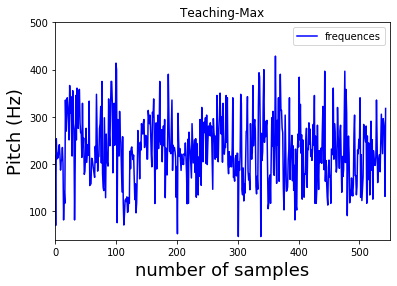

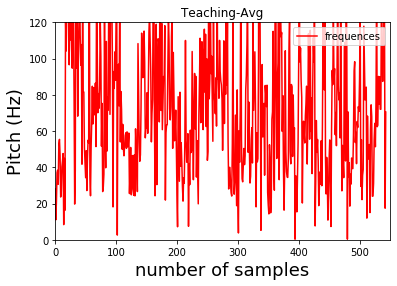

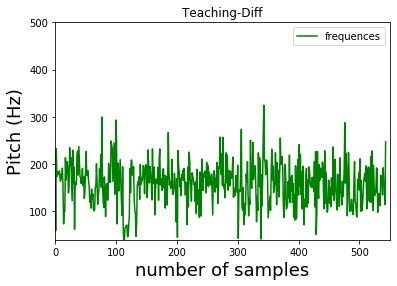

In [63]:
if __name__ == "__main__":
    App_Entry()
    #appRun()
    #wave_run()
    #yaapt_frequence_estimate()
    #RunApp_YAAPT()
    

In [20]:
#use wave module : The total frame is 130779231
#_audio_len's length is 130779231

In [ ]:
#Frames:130779231, Sample_Rate:48000, Seconds:2724.5673125  (using wave module)